### Diabetes Feature Engineering

**İş Problemi**

Özellikleri belirtildiğinde kişilerin diyabet hastası olup olmadıklarını tahmin edebilecek bir makine öğrenmesi modeli geliştirilmesi istenmektedir. Modeli geliştirmeden önce gerekli olan veri analizi ve özellik mühendisliği adımlarını gerçekleştirmeniz beklenmektedir.

**Veri Seti Hikayesi**

Veri seti ABD'deki Ulusal Diyabet-Sindirim-Böbrek Hastalıkları Enstitüleri'nde tutulan büyük veri setinin parçasıdır. ABD'deki Arizona Eyaleti'nin en büyük 5. şehri olan Phoenix şehrinde yaşayan 21 yaş ve üzerinde olan **Pima Indian** kadınları üzerinde yapılan diyabet araştırması için kullanılan verilerdir. Hedef değişken **"outcome"** olarak belirtilmiş olup; **1 diyabet** test sonucunun **pozitif** oluşunu, **0** ise **negatif** oluşunu belirtmektedir.

**Değişkenler**

**Pregnancies:** Hamilelik sayısı

**Glucose:** Glikoz.

**BloodPressure:** Kan basıncı.

**SkinThickness:** Cilt Kalınlığı

**Insulin:** İnsülin.
 
**BMI:** Beden kitle indeksi.
 
**DiabetesPedigreeFunction:** Soyumuzdaki kişilere göre diyabet olma ihtimalimizi hesaplayan bir  fonksiyon.
 
**Age:** Yaş (yıl)

**Outcome:** Kişinin diyabet olup olmadığı bilgisi. Hastalığa sahip (1) ya da değil (0).

#### Görev 1: Keşifçi Veri Analizi

**Adım 1:** Genel resmi inceleyiniz.

In [1]:
# Gerekli kütüphane ve fonksiyonların kurulması

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.float_format', lambda x: '%.3f' % x)

diabetes = pd.read_csv("datasets/diabetes.csv")

df = diabetes.copy()

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [2]:
df.shape

(768, 9)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000,3.845,3.370,0.000,1.000,3.000,6.000,17.000
Glucose,768.000,120.895,31.973,0.000,99.000,117.000,140.250,199.000
BloodPressure,768.000,69.105,19.356,0.000,62.000,72.000,80.000,122.000
SkinThickness,768.000,20.536,15.952,0.000,0.000,23.000,32.000,99.000
Insulin,768.000,79.799,115.244,0.000,0.000,30.500,127.250,846.000
BMI,768.000,31.993,7.884,0.000,27.300,32.000,36.600,67.100
DiabetesPedigreeFunction,768.000,0.472,0.331,0.078,0.244,0.372,0.626,2.420
Age,768.000,33.241,11.760,21.000,24.000,29.000,41.000,81.000
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


**Adım 2:** Numerik ve kategorik değişkenleri yakalayınız.

In [5]:
def grab_col_names(dataframe, cat_th = 10, car_th = 20):
    
    """
    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optional
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.

    """
    # cat_cols, cat_but_car
    cat_cols    = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if
                   dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if
                   dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [6]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [7]:
cat_cols

['Outcome']

In [8]:
num_cols

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

In [9]:
cat_but_car

[]

**Adım 3:** Numerik ve Kategorik değişkenlerin analizini yapınız.

In [10]:
# Kategorik Değişkenlerin Analizi

def cat_summary(dataframe, col_name, plot = False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x = dataframe[col_name], data = dataframe)
        plt.show(block = True)


In [11]:
cat_summary(df, "Outcome")

   Outcome  Ratio
0      500 65.104
1      268 34.896
##########################################


In [12]:
# Numerik Değişkenlerin Analizi

def num_summary(dataframe, numerical_col, plot = False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins = 20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

count   768.000
mean      3.845
std       3.370
min       0.000
5%        0.000
10%       0.000
20%       1.000
30%       1.000
40%       2.000
50%       3.000
60%       4.000
70%       5.000
80%       7.000
90%       9.000
95%      10.000
99%      13.000
max      17.000
Name: Pregnancies, dtype: float64


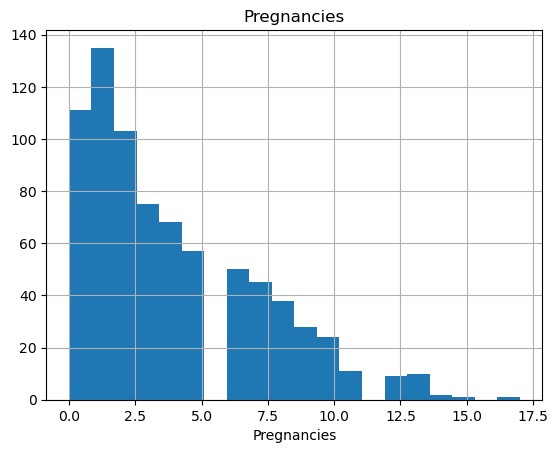

count   768.000
mean    120.895
std      31.973
min       0.000
5%       79.000
10%      85.000
20%      95.000
30%     102.000
40%     109.000
50%     117.000
60%     125.000
70%     134.000
80%     147.000
90%     167.000
95%     181.000
99%     196.000
max     199.000
Name: Glucose, dtype: float64


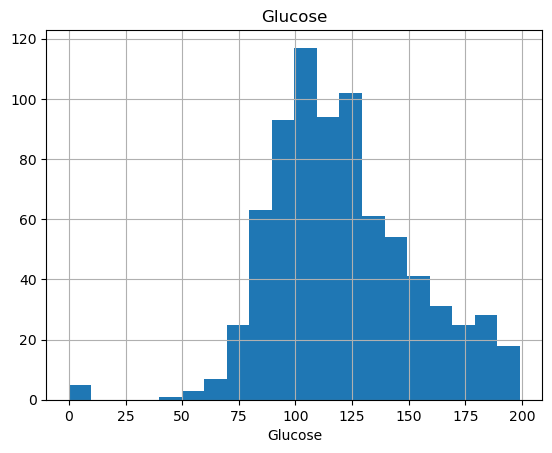

count   768.000
mean     69.105
std      19.356
min       0.000
5%       38.700
10%      54.000
20%      60.000
30%      64.000
40%      68.000
50%      72.000
60%      74.000
70%      78.000
80%      82.000
90%      88.000
95%      90.000
99%     106.000
max     122.000
Name: BloodPressure, dtype: float64


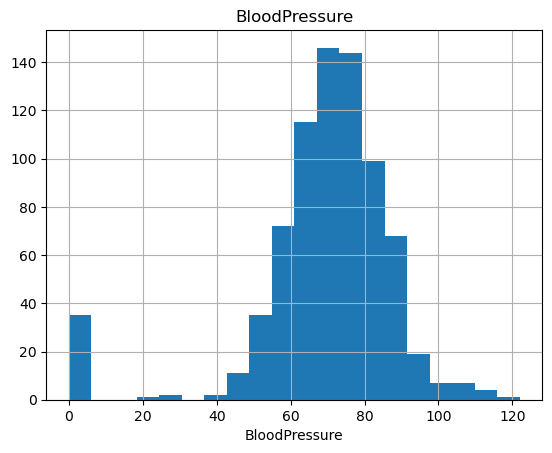

count   768.000
mean     20.536
std      15.952
min       0.000
5%        0.000
10%       0.000
20%       0.000
30%       8.200
40%      18.000
50%      23.000
60%      27.000
70%      31.000
80%      35.000
90%      40.000
95%      44.000
99%      51.330
max      99.000
Name: SkinThickness, dtype: float64


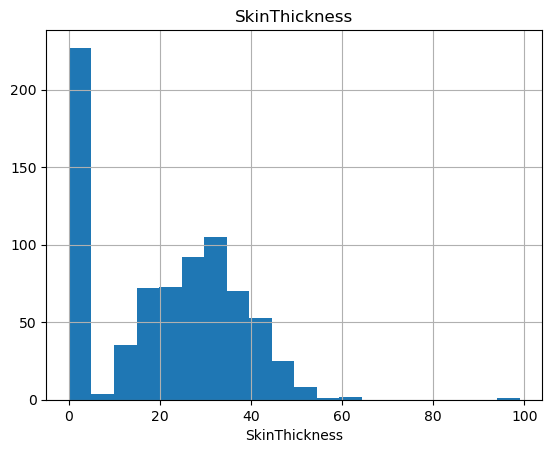

count   768.000
mean     79.799
std     115.244
min       0.000
5%        0.000
10%       0.000
20%       0.000
30%       0.000
40%       0.000
50%      30.500
60%      72.200
70%     106.000
80%     150.000
90%     210.000
95%     293.000
99%     519.900
max     846.000
Name: Insulin, dtype: float64


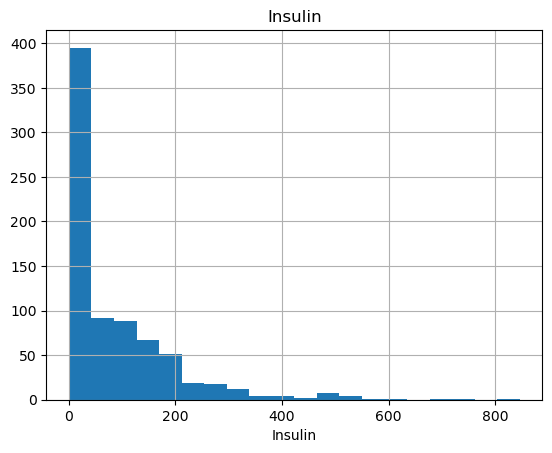

count   768.000
mean     31.993
std       7.884
min       0.000
5%       21.800
10%      23.600
20%      25.900
30%      28.200
40%      30.100
50%      32.000
60%      33.700
70%      35.490
80%      37.800
90%      41.500
95%      44.395
99%      50.759
max      67.100
Name: BMI, dtype: float64


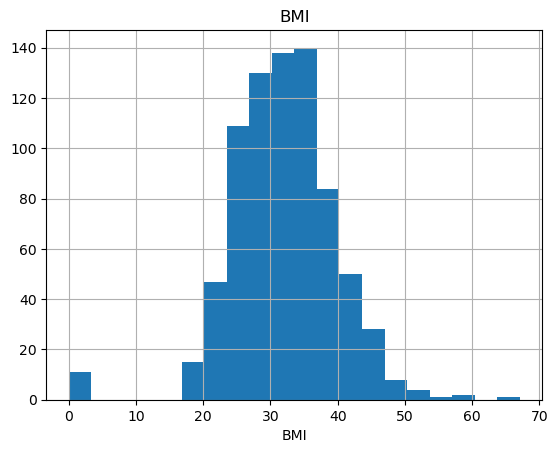

count   768.000
mean      0.472
std       0.331
min       0.078
5%        0.140
10%       0.165
20%       0.219
30%       0.259
40%       0.303
50%       0.372
60%       0.454
70%       0.564
80%       0.687
90%       0.879
95%       1.133
99%       1.698
max       2.420
Name: DiabetesPedigreeFunction, dtype: float64


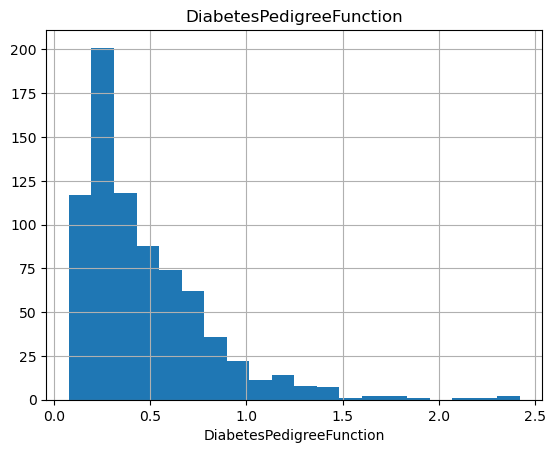

count   768.000
mean     33.241
std      11.760
min      21.000
5%       21.000
10%      22.000
20%      23.000
30%      25.000
40%      27.000
50%      29.000
60%      33.000
70%      38.000
80%      42.600
90%      51.000
95%      58.000
99%      67.000
max      81.000
Name: Age, dtype: float64


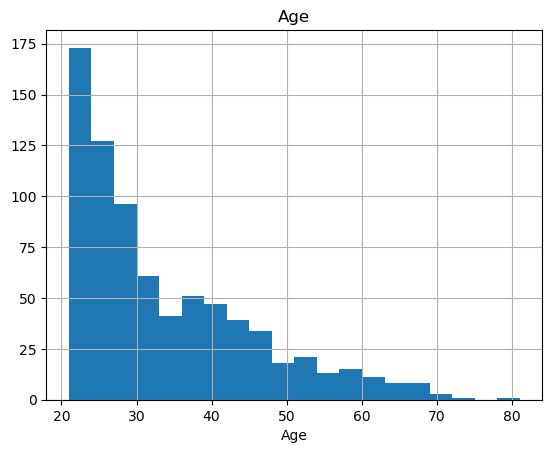

In [13]:
for col in num_cols:
    num_summary(df, col, plot = True)


**Adım 4:** Hedef değişken analizi yapınız. (Kategorik değişkenlere göre hedef değişkenin ortalaması, hedef değişkene göre numerik değişkenlerin ortalaması)

In [14]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end = "\n\n\n")


In [15]:
for col in num_cols:
    target_summary_with_num(df, "Outcome", col)

         Pregnancies
Outcome             
0              3.298
1              4.866


         Glucose
Outcome         
0        109.980
1        141.257


         BloodPressure
Outcome               
0               68.184
1               70.825


         SkinThickness
Outcome               
0               19.664
1               22.164


         Insulin
Outcome         
0         68.792
1        100.336


           BMI
Outcome       
0       30.304
1       35.143


         DiabetesPedigreeFunction
Outcome                          
0                           0.430
1                           0.550


           Age
Outcome       
0       31.190
1       37.067




In [16]:
# Korelasyon

df.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000,0.129,0.141,-0.082,-0.074,0.018,-0.034,0.544,0.222
Glucose,0.129,1.000,0.153,0.057,0.331,0.221,0.137,0.264,0.467
BloodPressure,0.141,0.153,1.000,0.207,0.089,0.282,0.041,0.240,0.065
SkinThickness,-0.082,0.057,0.207,1.000,0.437,0.393,0.184,-0.114,0.075
Insulin,-0.074,0.331,0.089,0.437,1.000,0.198,0.185,-0.042,0.131
BMI,0.018,0.221,0.282,0.393,0.198,1.000,0.141,0.036,0.293
DiabetesPedigreeFunction,-0.034,0.137,0.041,0.184,0.185,0.141,1.000,0.034,0.174
Age,0.544,0.264,0.240,-0.114,-0.042,0.036,0.034,1.000,0.238
Outcome,0.222,0.467,0.065,0.075,0.131,0.293,0.174,0.238,1.000


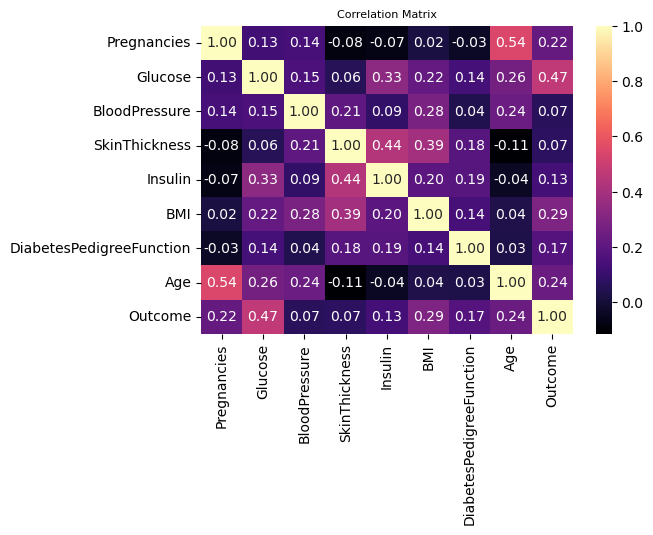

In [17]:
# korelasyon matrisi

f, ax = plt.subplots(figsize = [6, 4])
sns.heatmap(df.corr(), annot = True, fmt = ".2f", ax = ax, cmap = "magma")
ax.set_title("Correlation Matrix", fontsize = 8)

plt.show()


In [18]:
# Base Model Kurulumu

y = df["Outcome"]
X = df.drop("Outcome", axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 17)

In [19]:
rf_model = RandomForestClassifier(random_state = 46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [20]:
print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred, y_test), 3)}")
print(f"Precision: {round(precision_score(y_pred, y_test), 2)}")
print(f"F1: {round(f1_score(y_pred, y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred, y_test), 2)}")

Accuracy: 0.77
Recall: 0.706
Precision: 0.59
F1: 0.64
Auc: 0.75


In [21]:
# Accuracy: 0.77
# Recall: 0.706
# Precision: 0.59
# F1: 0.64
# Auc: 0.75

In [22]:
def plot_importance(model, features, num = len(X), save = False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize = (6, 4))
    sns.set(font_scale = 1)
    sns.barplot(x = "Value", y = "Feature", data = feature_imp.sort_values(by = "Value",
                                                                     ascending = False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

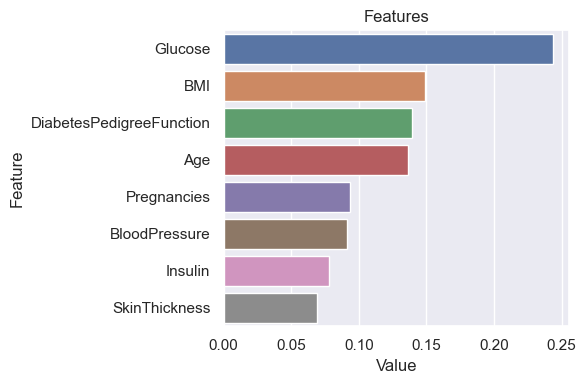

In [23]:
plot_importance(rf_model, X)

**Adım 5:** Aykırı gözlem analizi yapınız.

In [24]:
def outlier_thresholds(dataframe, col_name, q1 = 0.05, q3 = 0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit  = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [25]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit)|(dataframe[col_name] < low_limit)].any(axis = None):
        return True
    else:
        return False
    

In [26]:
def replace_with_thresholds(dataframe, variable, q1 = 0.05, q3 = 0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1 = 0.05, q3 = 0.95)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [27]:
# Aykırı Değer Analizi ve Baskılama İşlemi

for col in df.columns:
    print(col, check_outlier(df, col))
    if check_outlier(df, col):
        replace_with_thresholds(df, col)

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin True
BMI False
DiabetesPedigreeFunction False
Age False
Outcome False


**Adım 6:** Eksik gözlem Analizi Yapınız.

In [28]:
def missing_values_table(dataframe, na_name = False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending = False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending = False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis = 1, keys = ["n_miss", "ratio"])
    print(missing_df, end = "\n")
    if na_name:
        return na_columns

In [29]:
missing_values_table(df)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


**Adım 7:** Korelasyon analizi yapınız.

In [30]:
corr = df[num_cols].corr()
corr

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Pregnancies,1.000,0.129,0.141,-0.082,-0.073,0.018,-0.034,0.544
Glucose,0.129,1.000,0.153,0.057,0.331,0.221,0.137,0.264
BloodPressure,0.141,0.153,1.000,0.207,0.090,0.282,0.041,0.240
SkinThickness,-0.082,0.057,0.207,1.000,0.440,0.393,0.184,-0.114
Insulin,-0.073,0.331,0.090,0.440,1.000,0.200,0.186,-0.045
BMI,0.018,0.221,0.282,0.393,0.200,1.000,0.141,0.036
DiabetesPedigreeFunction,-0.034,0.137,0.041,0.184,0.186,0.141,1.000,0.034
Age,0.544,0.264,0.240,-0.114,-0.045,0.036,0.034,1.000


#### Görev 2: Feature Engineering

**Adım 1:** Eksik ve aykırı değerler için gerekli işlemleri yapınız. Veri setinde eksik gözlem bulunmamakta Glikoz, Insulin vb. değişkenlerde 0 değeri içeren gözlem birimleri eksik değeri ifade ediyor olabilir. Örneğin; bir kişinin glikoz veya insulin değeri 0 olamayacaktır. Bu durumu dikkate alarak sıfır değerini ilgili değerlerde NaN olarak atama yapıp sonrasında eksik değerlere işlemleri uygulayabilirsiniz.

In [31]:
zero_columns = [col for col in df.columns if (df[col].min() == 0 and col not in ["Pregnancies", "Outcome"])]
zero_columns

['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

In [32]:
# Gözlem birimlerinde 0 olan değişkenlerin her birisine gidip 0 içeren gözlem değerlerini NaN ile değiştirdik.

for col in zero_columns:
    df[col] = np.where(df[col] == 0, np.nan, df[col])

In [33]:
# Eksik Gözlem Analizi

In [34]:
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [35]:
def missing_values_table(dataframe, na_name = False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending = False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending = False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis = 1, keys = ["n_miss", "ratio"])
    print(missing_df, end = "\n")
    if na_name:
        return na_columns

In [36]:
na_columns = missing_values_table(df, na_name = True)

               n_miss  ratio
Insulin           374 48.700
SkinThickness     227 29.560
BloodPressure      35  4.560
BMI                11  1.430
Glucose             5  0.650


In [37]:
# Eksik Değerlerin Bağımlı Değişken ile İlişkisinin İncelenmesi

In [38]:
def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()
    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)
    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns
    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end = "\n\n\n")

In [39]:
missing_vs_target(df, "Outcome", na_columns)

                 TARGET_MEAN  Count
Glucose_NA_FLAG                    
0                      0.349    763
1                      0.400      5


                       TARGET_MEAN  Count
BloodPressure_NA_FLAG                    
0                            0.344    733
1                            0.457     35


                       TARGET_MEAN  Count
SkinThickness_NA_FLAG                    
0                            0.333    541
1                            0.388    227


                 TARGET_MEAN  Count
Insulin_NA_FLAG                    
0                      0.330    394
1                      0.369    374


             TARGET_MEAN  Count
BMI_NA_FLAG                    
0                  0.351    757
1                  0.182     11




In [40]:
# Eksik Değerlerin Doldurulması

for col in zero_columns:
    df.loc[df[col].isnull(), col] = df[col].median()

df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

**Adım 2:** Yeni değişkenler oluşturunuz.

In [41]:
# Özellik Çıkarımı

In [42]:
# Yaş değişkenini kategorilere ayırıp yeni yaş değişkeni oluşturulması

df.loc[(df["Age"] >= 21) & (df["Age"] < 50), "NEW_AGE_CAT"] = "mature"
df.loc[(df["Age"] >= 50), "NEW_AGE_CAT"] = "senior"

In [43]:
# BMI 18,5 aşağısı underweight, 18.5 ile 24.9 arası normal, 24.9 ile 29.9 arası Overweight ve 30 üstü obez

df["NEW_BMI"] = pd.cut(x = df["BMI"], bins = [0, 18.5, 24.9, 29.9, 100],
                       labels = ["Underweight", "Healthy", "Overweight", "Obese"])

In [44]:
# Glukoz degerini kategorik değişkene çevirme

df["NEW_GLUCOSE"] = pd.cut(x = df["Glucose"], bins = [0, 140, 200, 300], labels = ["Normal", "Prediabetes", "Diabetes"])

In [45]:
#  Yaş ve beden kitle indeksini bir arada düşünerek kategorik değişken oluşturma

df.loc[(df["BMI"] < 18.5) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "underweightmature"
df.loc[(df["BMI"] < 18.5) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "underweightsenior"
df.loc[((df["BMI"] >= 18.5) & (df["BMI"] < 25)) & (
        (df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "healthymature"
df.loc[((df["BMI"] >= 18.5) & (df["BMI"] < 25)) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "healthysenior"
df.loc[((df["BMI"] >= 25) & (df["BMI"] < 30)) & (
        (df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "overweightmature"
df.loc[((df["BMI"] >= 25) & (df["BMI"] < 30)) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "overweightsenior"
df.loc[(df["BMI"] > 18.5) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "obesemature"
df.loc[(df["BMI"] > 18.5) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "obesesenior"

In [46]:
# Yaş ve Glikoz değerlerini bir arada düşünerek kategorik değişken oluşturma

df.loc[(df["Glucose"] < 70) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "lowmature"
df.loc[(df["Glucose"] < 70) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "lowsenior"
df.loc[((df["Glucose"] >= 70) & (df["Glucose"] < 100)) & (
        (df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "normalmature"
df.loc[((df["Glucose"] >= 70) & (df["Glucose"] < 100)) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "normalsenior"
df.loc[((df["Glucose"] >= 100) & (df["Glucose"] <= 125)) & (
        (df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "hiddenmature"
df.loc[((df["Glucose"] >= 100) & (df["Glucose"] <= 125)) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "hiddensenior"
df.loc[(df["Glucose"] > 125) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "highmature"
df.loc[(df["Glucose"] > 125) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "highsenior"

In [47]:
# İnsulin Değeri ile Kategorik değişken türetmek

def set_insulin(dataframe, col_name = "Insulin"):
    if 16 <= dataframe[col_name] <= 166:
        return "Normal"
    else:
        return "Annormal"

In [48]:
df["NEW_INSULIN_SCORE"] = df.apply(set_insulin, axis = 1)

df["NEW_GLUCOSE*INSULIN"] = df["Glucose"] * df["Insulin"]

df["NEW_GLUCOSE*PREGNANCIES"] = df["Glucose"] * df["Pregnancies"]

In [49]:
# Kolonların büyültülmesi

df.columns = [col.upper() for col in df.columns]

In [50]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_BMI,NEW_GLUCOSE,NEW_AGE_BMI_NOM,NEW_AGE_GLUCOSE_NOM,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,senior,Obese,Prediabetes,obesesenior,highsenior,Normal,18500.000,888.000
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,mature,Overweight,Normal,obesemature,normalmature,Normal,10625.000,85.000
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,mature,Healthy,Prediabetes,obesemature,highmature,Normal,22875.000,1464.000
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,mature,Overweight,Normal,obesemature,normalmature,Normal,8366.000,89.000
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,mature,Obese,Normal,obesemature,highmature,Annormal,23016.000,0.000


In [51]:
df.shape

(768, 17)

**Adım 3:** Encoding işlemlerini gerçekleştiriniz.

In [52]:
# Değişkenlerin tiplerine göre ayrılması işlemi

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 17
cat_cols: 7
num_cols: 10
cat_but_car: 0
num_but_cat: 3


In [53]:
# Label Encoding

def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [54]:
binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]

binary_cols

['NEW_AGE_CAT', 'NEW_INSULIN_SCORE']

In [55]:
for col in binary_cols:
    df = label_encoder(df, col)

In [56]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_BMI,NEW_GLUCOSE,NEW_AGE_BMI_NOM,NEW_AGE_GLUCOSE_NOM,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,1,Obese,Prediabetes,obesesenior,highsenior,1,18500.000,888.000
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,0,Overweight,Normal,obesemature,normalmature,1,10625.000,85.000
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,0,Healthy,Prediabetes,obesemature,highmature,1,22875.000,1464.000
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,0,Overweight,Normal,obesemature,normalmature,1,8366.000,89.000
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,0,Obese,Normal,obesemature,highmature,0,23016.000,0.000


In [57]:
# One-Hot Encoding İşlemi

# cat_cols listesinin güncelleme işlemi

cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["OUTCOME"]]
cat_cols

['NEW_AGE_BMI_NOM', 'NEW_AGE_GLUCOSE_NOM', 'NEW_BMI', 'NEW_GLUCOSE']

In [58]:
def one_hot_encoder(dataframe, categorical_cols, drop_first = False):
    dataframe = pd.get_dummies(dataframe, columns = categorical_cols, drop_first = drop_first)
    return dataframe

In [59]:
df = one_hot_encoder(df, cat_cols, drop_first = True)

In [60]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,...,NEW_AGE_GLUCOSE_NOM_highsenior,NEW_AGE_GLUCOSE_NOM_lowmature,NEW_AGE_GLUCOSE_NOM_lowsenior,NEW_AGE_GLUCOSE_NOM_normalmature,NEW_AGE_GLUCOSE_NOM_normalsenior,NEW_BMI_Healthy,NEW_BMI_Overweight,NEW_BMI_Obese,NEW_GLUCOSE_Prediabetes,NEW_GLUCOSE_Diabetes
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,1,...,1,0,0,0,0,0,0,1,1,0
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,0,...,0,0,0,1,0,0,1,0,0,0
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,0,...,0,0,0,0,0,1,0,0,1,0
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,0,...,0,0,0,1,0,0,1,0,0,0
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,0,...,0,0,0,0,0,0,0,1,0,0


In [61]:
df.shape

(768, 27)

**Adım 4:** Numerik değişkenler için standartlaştırma yapınız.

In [62]:
num_cols

['PREGNANCIES',
 'GLUCOSE',
 'BLOODPRESSURE',
 'SKINTHICKNESS',
 'INSULIN',
 'BMI',
 'DIABETESPEDIGREEFUNCTION',
 'AGE',
 'NEW_GLUCOSE*INSULIN',
 'NEW_GLUCOSE*PREGNANCIES']

In [63]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [64]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,...,NEW_AGE_GLUCOSE_NOM_highsenior,NEW_AGE_GLUCOSE_NOM_lowmature,NEW_AGE_GLUCOSE_NOM_lowsenior,NEW_AGE_GLUCOSE_NOM_normalmature,NEW_AGE_GLUCOSE_NOM_normalsenior,NEW_BMI_Healthy,NEW_BMI_Overweight,NEW_BMI_Obese,NEW_GLUCOSE_Prediabetes,NEW_GLUCOSE_Diabetes
0,0.640,0.866,-0.032,0.671,-0.182,0.167,0.468,1.426,1,1,...,1,0,0,0,0,0,0,1,1,0
1,-0.845,-1.205,-0.528,-0.012,-0.182,-0.852,-0.365,-0.191,0,0,...,0,0,0,1,0,0,1,0,0,0
2,1.234,2.017,-0.694,-0.012,-0.182,-1.333,0.604,-0.106,1,0,...,0,0,0,0,0,1,0,0,1,0
3,-0.845,-1.074,-0.528,-0.695,-0.546,-0.634,-0.921,-1.042,0,0,...,0,0,0,1,0,0,1,0,0,0
4,-1.142,0.504,-2.679,0.671,0.323,1.549,5.485,-0.020,1,0,...,0,0,0,0,0,0,0,1,0,0


In [65]:
df.shape

(768, 27)

**Adım 5:** Model Oluşturunuz.

In [66]:
y = df["OUTCOME"]
X = df.drop("OUTCOME", axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 17)

In [67]:
rf_model = RandomForestClassifier(random_state = 46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [68]:
print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred, y_test), 3)}")
print(f"Precision: {round(precision_score(y_pred, y_test), 2)}")
print(f"F1: {round(f1_score(y_pred, y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred, y_test), 2)}")

Accuracy: 0.79
Recall: 0.711
Precision: 0.67
F1: 0.69
Auc: 0.77


In [69]:
# Feature Importence

    Value                            Feature
1   0.138                            GLUCOSE
10  0.131                NEW_GLUCOSE*INSULIN
5   0.099                                BMI
11  0.098            NEW_GLUCOSE*PREGNANCIES
7   0.097                                AGE
6   0.094           DIABETESPEDIGREEFUNCTION
2   0.059                      BLOODPRESSURE
0   0.051                        PREGNANCIES
4   0.051                            INSULIN
24  0.050            NEW_GLUCOSE_Prediabetes
3   0.046                      SKINTHICKNESS
19  0.017   NEW_AGE_GLUCOSE_NOM_normalmature
15  0.014     NEW_AGE_GLUCOSE_NOM_highmature
23  0.014                      NEW_BMI_Obese
21  0.010                    NEW_BMI_Healthy
22  0.008                 NEW_BMI_Overweight
9   0.006                  NEW_INSULIN_SCORE
8   0.005                        NEW_AGE_CAT
12  0.005        NEW_AGE_BMI_NOM_obesesenior
16  0.002     NEW_AGE_GLUCOSE_NOM_highsenior
14  0.002   NEW_AGE_GLUCOSE_NOM_hiddensenior
20  0.001 

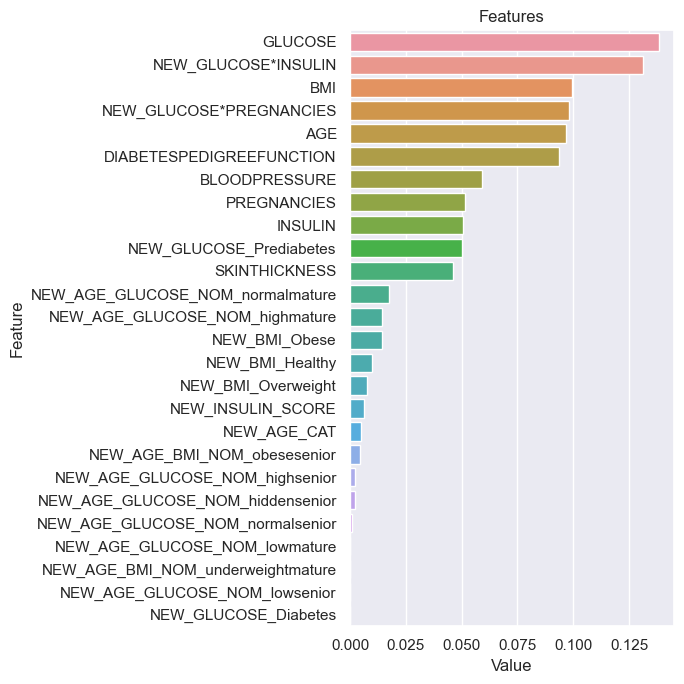

In [70]:
def plot_importance(model, features, num = len(X), save = False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    print(feature_imp.sort_values("Value",ascending = False))
    plt.figure(figsize = (7, 7))
    sns.set(font_scale = 1)
    sns.barplot(x = "Value", y = "Feature", data = feature_imp.sort_values(by = "Value",
                                                                     ascending = False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(rf_model, X)